In [1]:
import numpy as np
import matplotlib.pyplot as plt
import neuron
from neuron import h

h.load_file('stdrun.hoc')
mechanisms_dir = '../components/mechanisms'
templates_file = '../components/templates/templates.hoc'
neuron.load_mechanisms(mechanisms_dir)
h.load_file(templates_file) # reads in template

pc = h.ParallelContext()

h.dt = 0.025 # time step (resolution) of the simulation in ms
h.steps_per_ms = 1 / h.dt
h.celsius = 36.0

In [2]:
Cell = 'LTS_Cell'
t_start = 500
t_end = 1000

In [3]:
h.tstop = t_end + 100.

cell1 = getattr(h, Cell)()
cell2 = getattr(h, Cell)()

icl = h.IClamp(cell1.soma[0](0.5))
icl.delay = t_start
icl.dur = t_end - t_start
icl.amp = -0.01 # nA

In [4]:
sec1 = cell1.soma[0]
sec2 = cell2.soma[0]

pc.source_var(sec1(0.5)._ref_v, 0, sec=sec1)
gap_junc_1 = h.Gap(sec1(0.5))
pc.target_var(gap_junc_1._ref_vgap, 1)

pc.source_var(sec2(0.5)._ref_v, 1, sec=sec2)
gap_junc_2 = h.Gap(sec2(0.5))
pc.target_var(gap_junc_2._ref_vgap, 0)

pc.setup_transfer()

0.0

In [5]:
## Using POINTER in mod file
# gap_junc_1 = h.Gap(cell1.soma[0](0.5))
# gap_junc_2 = h.Gap(cell2.soma[0](0.5))
# gap_junc_1._ref_vgap = cell2.soma[0](0.5)._ref_v
# gap_junc_2._ref_vgap = cell1.soma[0](0.5)._ref_v

In [6]:
t_vec = h.Vector()
soma_v_1 = h.Vector()
soma_v_2 = h.Vector()
t_vec.record(h._ref_t)
soma_v_1.record(cell1.soma[0](0.5)._ref_v)
soma_v_2.record(cell2.soma[0](0.5)._ref_v)

Vector[2]

In [7]:
g_gap = {'FSI_Cell': 0.00033, 'LTS_Cell': 0.00038}
g = g_gap[Cell]
gap_junc_1.g = g
gap_junc_2.g = g
print(f'Resistance: {1/g:.4g} MOhms')

Resistance: 2632 MOhms


In [8]:
h.run()

0.0

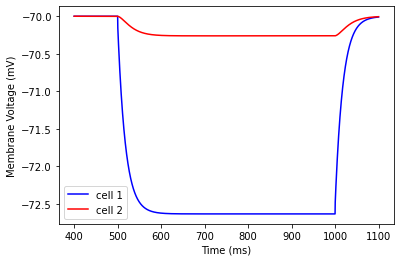

In [9]:
t_range = [t_start - 100., t_end + 100.]
t = np.array(t_vec)
v1 = np.array(soma_v_1)
v2 = np.array(soma_v_2)
tidx = (t >= t_range[0]) & (t <= t_range[1])

plt.figure()
plt.plot(t[tidx], v1[tidx], 'b', label='cell 1')
plt.plot(t[tidx], v2[tidx], 'r', label='cell 2')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Voltage (mV)')
plt.legend()
plt.show()

In [10]:
def coupling_coefficient(t, v1, v2, t_start, t_end, dt=h.dt):
    t = np.asarray(t)
    v1 = np.asarray(v1)
    v2 = np.asarray(v2)
    idx1 = np.nonzero(t < t_start)[0][-1]
    idx2 = np.nonzero(t < t_end)[0][-1]
    return (v2[idx2] - v2[idx1]) / (v1[idx2] - v1[idx1])

cc = coupling_coefficient(t, soma_v_1, soma_v_2, 500, 1000)
print(cc)

0.09920377907793838
